# Mid-level feature differences underlie early animacy and object size distinctions: Evidencefrom EEG decoding 

This notebook contains the code for the main analysis of the following paper:

Ruosi Wang, Daniel Janini, & Talia Konkle. Mid-level feature differences underlie early animacy and object size distinctions: Evidence from EEG decoding. [link to the axiv]


**Highlights**

---
**Main Results**
* <a href='#stimuli'>Stimuli examples</a>
* <a href='#anim-decoding'>Animate vs Inanimate Decoding</a>
    - <a href='#anim-decoding-scores'>Time-resolved decoding</a>
    - <a href='#anim-decoding-timing'>Onset and peak Latencies</a>
    - <a href='#anim-cross-viz'>Visualizations of cross decoding</a>
* <a href='#size-decoding'>Big vs Small Decoding</a>
    - <a href='#size-decoding-scores'>Time-resolved decoding</a>
    - <a href='#size-decoding-timing'>Onset and peak latenceis</a>
    - <a href='#size-cross-viz'>Visualizations of cross decoding</a>
    - <a href='#tripartite'>Tripartite Organizations</a>
* <a href="#pairwise-decoding">Pairwise Decoding</a>
* <a href='#suppl'>Supplementary figures</a>

#### Getting started

In [1]:
# Required Libraries
%matplotlib inline

import sys
from itertools import product, combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.eeg.data import GroupModel
from src.viz.stim import plot_stim_examples
from src.viz.timecourse import (plot_category_decoding, 
                                plot_tri_category_decoding,
                                plot_pair_decoding)
from src.viz.mdsplot import (plot_tri_decoding_viz, 
                             plot_cross_decoding_viz)
from src.viz.utils import set_rcParams
 
set_rcParams('notebook')

In [2]:
# Hard Coded Parameters

N_ITERS = 5000  # number of bootstrapping iterations

# set 
FIGSIZE = {
    'stim': (1.65, 1.65),
    'stim_suppl': (6, 2.5),
    'time_course': (3, 2.1),
    'cross_mds': (1.35, 1.35),
    'tri_mds': (1.85, 1.85)
}

# decoding parameters
DECODINGS = {
    'original': ('original', False),    # original => original  
    'texform': ('texform', False),      # texform  => texform   
    'cross': ('texform', True)          # texform  => original  
}

SUPPL_DECODINGS = {
    'original': ('original', True),    # original => texform 
}

## <a id='stimuli'>Stimulus examples</a>
Fifteen total exemplars were included for the four *animacy* x *size* conditions , yielding 60 unrecognizable *texforms* and their 60 *original* counterparts. Here are a set of example stimulus images. 

Fig 1A. Stimulus Examples


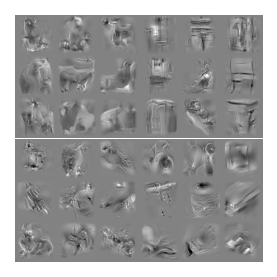

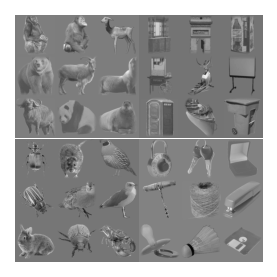

In [3]:
# Fig 1A. Stimuli
print('Fig 1A. Stimulus Examples')
plot_stim_examples('texform', figsize=FIGSIZE['stim']) # texform (upper)
plot_stim_examples('original', figsize=FIGSIZE['stim']) # original(lower)
plt.show(sns);

## <a id='anim-decoding'>Animate vs Inanimate Decoding</a>

### <a id='anim-decoding-scores'>Time-resolved decoding</a>

* Whether the neural responses to animate vs inanimate objects evoke measurably distinct spatial patterns for original images (*original*: solid silver) and texform images (*texform*: solid black). 
* Whether the distinct neural patterns that support the animacy distinction in texforms the same as those supporting animacy decoding in original images? (*cross*: dashed gray)


Fig 1B (left). Animal vs Object Decoding


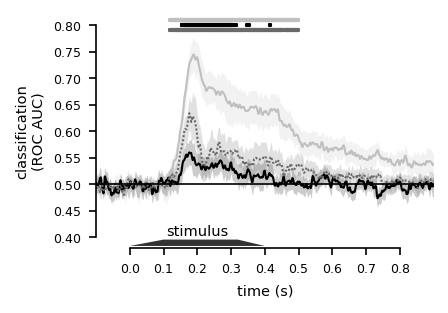

In [4]:
print('Fig 1B (left). Animal vs Object Decoding')
plot_category_decoding('animacy', DECODINGS.values(),
                       figsize=FIGSIZE['time_course'])
plt.show(sns);

### <a id='anim-decoding-timing'> Onset and Peak Latencies

#### Helper functions

In [5]:
from mne.stats import fdr_correction
from scipy.stats import wilcoxon


def make_df_latency_descriptives(category, latency_type, labels):
    grp = GroupModel()
    data = grp.load('timing_latency', category=category)
    
    descriptives = []
    for label in labels:
        vals = data[f'{label}_boot_{latency_type}'].squeeze()
        descriptives.append([
            data[f'{label}_{latency_type}'].squeeze(),
            np.nanmedian(vals), # bootstrapped median
            np.nanpercentile(vals, 25), # bootstrapped Q1
            np.nanpercentile(vals, 75), # bootstrapped Q3
            (np.nanpercentile(vals, 2.5).round(3), # bootstrapped CI
             np.nanpercentile(vals, 97.5).round(3))
        ])
    
    df = pd.DataFrame(descriptives, index=labels,
                      columns=['group', 'median', 'Q1', 'Q3', '95% CI'])
    df.index.name = f'{category}_{latency_type}'
    return df


def compare_latencies_between_stim_type(category, latency_type, labels):
    grp = GroupModel()
    data = grp.load('timing_latency', category=category)
    comparisons = list(combinations(labels, 2))
    results = dict(p=[])
    for cond1, cond2 in comparisons:
        results['p'].append(get_bootstrapping_p(data[f'{cond1}_boot_{latency_type}'], 
                                                data[f'{cond2}_boot_{latency_type}']))
    
    _, corrected_ps = fdr_correction(results['p'])
    results['corrected_ps'] = corrected_ps
    
    df =  pd.DataFrame(results, index= [f'{c1} vs {c2}' for c1, c2 in comparisons])
    df.index.name = f'{category}_{latency_type}'
    
    return df.round(3)


def compare_latencies_between_categories(latency_type, labels):
    grp = GroupModel()
    anim_data = grp.load('timing_latency', category='animacy')
    size_data = grp.load('timing_latency', category='size')
    
    results = dict(p=[])
    for label in labels:
        results['p'].append(get_bootstrapping_p(anim_data[f'{label}_boot_{latency_type}'], 
                                                size_data[f'{label}_boot_{latency_type}']))
        
    _, corrected_ps = fdr_correction(results['p'])
    results['corrected_ps'] = corrected_ps
    
    df =  pd.DataFrame(results, index=labels)
    df.index.name = latency_type
    
    return df.round(3)


def compare_peak_decoding(category, labels):
    grp = GroupModel()
    data = grp.load('timing_latency', category=category)
    times = data['timepoint'].squeeze()
    comparisons = list(combinations(labels, 2))
    
    results = dict(M1=[], M2=[], W=[], p=[])
    for cond1, cond2 in comparisons:
        cond1_peak = data[f'{cond1}_peak'].squeeze()
        cond2_peak = data[f'{cond2}_peak'].squeeze()
        
        cond1_peak_scores = data[f'{cond1}_score'][:, np.where(times==cond1_peak)[0][0]]
        cond2_peak_scores = data[f'{cond2}_score'][:, np.where(times==cond2_peak)[0][0]]

        w, p = wilcoxon(cond1_peak_scores, cond2_peak_scores)
        
        results['M1'].append(cond1_peak_scores.mean())
        results['M2'].append(cond2_peak_scores.mean())
        results['W'].append(w)
        results['p'].append(p)
        
    _, corrected_ps = fdr_correction(results['p'])
    results['corrected_ps'] = corrected_ps
    
    df = pd.DataFrame(results, index= [f'{c1} vs {c2}' for c1, c2 in comparisons])
    df.index.name = category
    
    return df.round(3)


def get_bootstrapping_p(x, y):
    return min(np.mean(x > y), np.mean(x < y)) * 2


def get_cross_decoding_peak(category):
    grp = GroupModel()
    data = grp.load('timing_latency', category=category)
    return data[f'cross_peak'].squeeze()

#### Descriptive Statistics
We first use descriptive statistics to summarize the onsets and peaks of animate vs inanimate decoding latencies.

In [6]:
make_df_latency_descriptives('animacy', 'onset', DECODINGS.keys())

,group,median,Q1,Q3,95% CI
animacy_onset,,,,,
original,0.126,0.124,0.120,0.126,"(0.116, 0.142)"
texform,0.152,0.152,0.146,0.154,"(0.106, 0.164)"
cross,0.14,0.140,0.124,0.144,"(0.114, 0.152)"


In [7]:
make_df_latency_descriptives('animacy', 'peak', DECODINGS.keys())

,group,median,Q1,Q3,95% CI
animacy_peak,,,,,
original,0.188,0.190,0.188,0.190,"(0.184, 0.2)"
texform,0.176,0.176,0.168,0.182,"(0.146, 0.19)"
cross,0.176,0.178,0.176,0.186,"(0.174, 0.192)"


#### Hypothesis testings

* **Q1**: Whether the *onset* latencies are different among _animate vs inanimate_ decoding time-courses? 

In [8]:
compare_latencies_between_stim_type('animacy', 'onset', DECODINGS.keys())

,p,corrected_ps
animacy_onset,,
original vs texform,0.164,0.338
original vs cross,0.440,0.440
texform vs cross,0.225,0.338


* **Q2**: Whether the *peak* latencies are different among _animate vs inanimate_ decoding time-courses?

In [9]:
compare_latencies_between_stim_type('animacy', 'peak', DECODINGS.keys())

,p,corrected_ps
animacy_peak,,
original vs texform,0.056,0.138
original vs cross,0.092,0.138
texform vs cross,0.462,0.462


* **Q3**: Whether the peak decoding performances are different among decoding time-courses?

In [10]:
compare_peak_decoding('animacy', DECODINGS.keys())

,M1,M2,W,p,corrected_ps
animacy,,,,,
original vs texform,0.745,0.560,0.0,0.0,0.0
original vs cross,0.745,0.634,0.0,0.0,0.0
texform vs cross,0.560,0.634,3.0,0.0,0.0


### <a id='anim-cross-viz'>Visual intuition for cross-decoding</a>
This multidimensional scaling (MDS) plot visualizes the neural pattern similarity structure among the *original* images (open dots) and *texform* images (filled dots) during the peak cross-decoding time at 176ms. *Animate* objects are colored purple and *inanimate* objects are colored green.

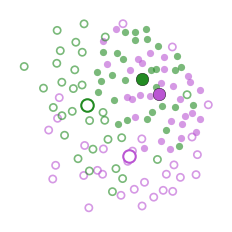

In [11]:
# Extract the peak latency of cross-decoding from the descriptive Dataframe  
anim_cross_peak = get_cross_decoding_peak('animacy')
plot_cross_decoding_viz('animacy', timepoint=anim_cross_peak,
                         figsize=FIGSIZE['cross_mds'])
plt.show(sns);

## <a id='size-decoding'> Big vs Small Decoding</a>

### <a id='size-decoding-scores'>Time-resolved decoding</a>
* Whether the neural responses to *big* vs *small* objects evoke measurably distinct spatial patterns for original images (*original*: solid silver) and texform images (*texform*: solid black). 
* Whether the distinct neural patterns that support the size distinction in texforms the same as those supporting size decoding in original images? (*cross*: dashed gray)

Fig 1C (left). Big vs Small Decoding


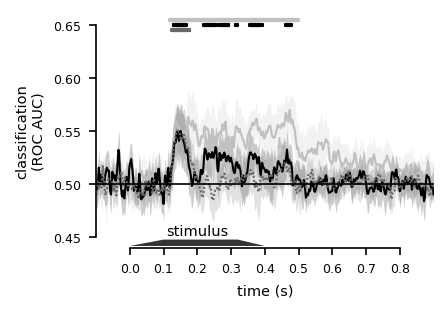

In [12]:
print('Fig 1C (left). Big vs Small Decoding')
plot_category_decoding('size', DECODINGS.values(),
                       figsize=FIGSIZE['time_course'])
plt.show(sns);

### <a id='size-decoding-timing'> Onset and peak latencies

#### Descriptive Statistics
We first use descriptive statistics to summarize the onsets and peaks of _big vs small_ decoding latencies.

In [13]:
make_df_latency_descriptives('size', 'onset', DECODINGS.keys())

,group,median,Q1,Q3,95% CI
size_onset,,,,,
original,0.12,0.120,0.118,0.122,"(0.114, 0.132)"
texform,0.13,0.130,0.128,0.136,"(0.12, 0.246)"
cross,0.124,0.124,0.124,0.126,"(0.12, 0.128)"


In [14]:
make_df_latency_descriptives('size', 'peak', DECODINGS.keys())

,group,median,Q1,Q3,95% CI
size_peak,,,,,
original,0.174,0.172,0.136,0.178,"(0.11, 0.194)"
texform,0.15,0.144,0.140,0.150,"(0.114, 0.162)"
cross,0.14,0.142,0.140,0.158,"(0.13, 0.172)"


#### Hypothsis testings

* **Q1**: Whether the *onset* latencies are different among _big vs small_ decoding time-courses? 

In [15]:
compare_latencies_between_stim_type('size', 'onset',  DECODINGS.keys())

,p,corrected_ps
size_onset,,
original vs texform,0.224,0.383
original vs cross,0.383,0.383
texform vs cross,0.279,0.383


* **Q2**: Whether the *peak* latencies are different among _big vs small_ decoding time-courses? 

In [16]:
compare_latencies_between_stim_type('size', 'peak',  DECODINGS.keys())

,p,corrected_ps
size_peak,,
original vs texform,0.656,0.881
original vs cross,0.632,0.881
texform vs cross,0.881,0.881


* **Q3**: Whether the *peak* decoding performances are different among *big* vs *small* decoding time-courses?

In [17]:
compare_peak_decoding('size', DECODINGS.keys())

,M1,M2,W,p,corrected_ps
size,,,,,
original vs texform,0.563,0.550,66.0,0.417,0.702
original vs cross,0.563,0.551,72.0,0.580,0.702
texform vs cross,0.550,0.551,76.0,0.702,0.702


* **Q4**: Whether the *onset* latencies are different between *animacy* decoding and *size* decoding?

In [18]:
compare_latencies_between_categories('onset', DECODINGS.keys())

,p,corrected_ps
onset,,
original,0.623,0.623
texform,0.338,0.623
cross,0.452,0.623


* **Q5**: Whether the *peak* latencies are different between *animacy* decoding and *size* decoding?

In [19]:
compare_latencies_between_categories('peak', DECODINGS.keys())

,p,corrected_ps
peak,,
original,0.065,0.065
texform,0.051,0.065
cross,0.002,0.005


### <a id='size-cross-viz'>Visual intuiation for cross-decoding</a>

Fig 1C (right). Visual intuition for Big vs Small cross-decoding


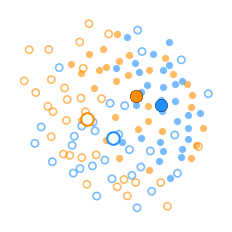

In [20]:
print('Fig 1C (right). Visual intuition for Big vs Small cross-decoding')

size_cross_peak = get_cross_decoding_peak('size')
plot_cross_decoding_viz('size', timepoint=size_cross_peak,
                        figsize=FIGSIZE['cross_mds'])
plt.show(sns);

### <a id='tripartite'>Tripartite Orgnizations</a>

#### Originals

Fig 3A. Original (upper)


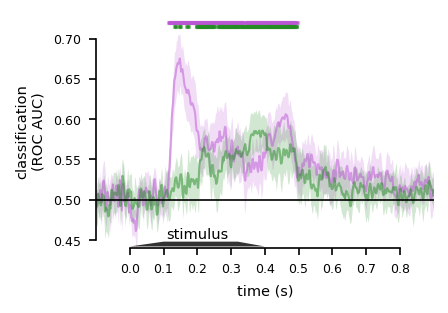

In [21]:
stim_type = 'original'

print(f'Fig 3A. {(stim_type.capitalize())} (upper)') 
plot_tri_category_decoding(stim_type, figsize=FIGSIZE['time_course'])
plt.show(sns);

Fig 3A. Original (lower)


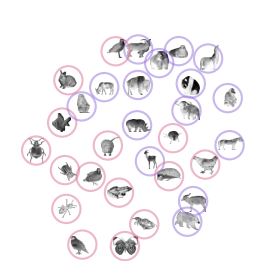

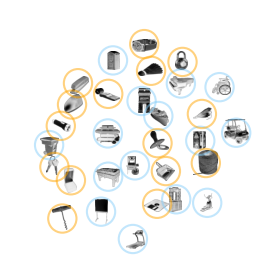

In [22]:
print(f'Fig 3A. {(stim_type.capitalize())} (lower)') 

size_cross_peak = get_cross_decoding_peak('size')

plot_tri_decoding_viz(stim_type, 'animate', timepoint=size_cross_peak, 
                      figsize=FIGSIZE['tri_mds'])
plot_tri_decoding_viz(stim_type, 'inanimate', timepoint=size_cross_peak, 
                      figsize=FIGSIZE['tri_mds'])
plt.show(sns);

#### Texforms

Fig 3B. Texform (upper)


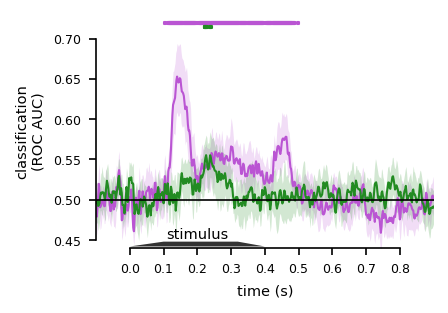

In [23]:
stim_type = 'texform'

print(f'Fig 3B. {(stim_type.capitalize())} (upper)') 
plot_tri_category_decoding(stim_type, figsize=FIGSIZE['time_course'])
plt.show(sns);

Fig 3B. Texform (lower)


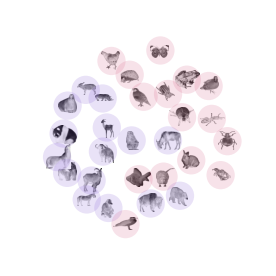

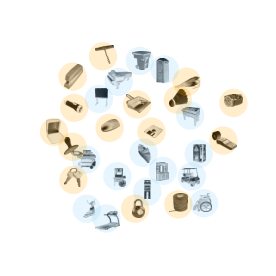

In [24]:
print(f'Fig 3B. {(stim_type.capitalize())} (lower)') 

plot_tri_decoding_viz(stim_type, 'animate', timepoint=size_cross_peak, 
                      figsize=FIGSIZE['tri_mds'])
plot_tri_decoding_viz(stim_type, 'inanimate', timepoint=size_cross_peak, 
                      figsize=FIGSIZE['tri_mds'])
plt.show(sns);

## <a id='pairwise-decoding'>Pairwise Decoding</a>

Fig 2. Pairwise Decoding


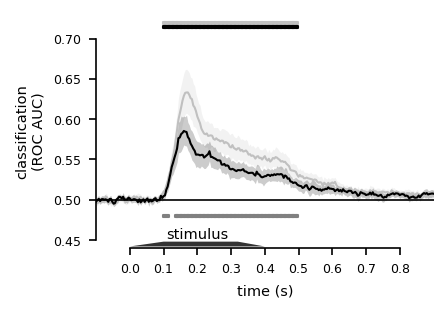

In [25]:
print(f'Fig 2. Pairwise Decoding') 
plot_pair_decoding(figsize=FIGSIZE['time_course'])
plt.show(sns);

## <a id='qa'>QA</a>

### <a id='numoftrials'>Num of trials</a>
We would like to make sure the number of trials are comparable across conditions after artifect rejection.

#### Helper Functions

In [26]:
import pingouin as pg

def make_df_n_trials_by_cond():
    # load data
    grp = GroupModel()
    data = grp.load('qa_n_trials', by='condition')

    n_trials = data['n_trials']
    conditions = list(data['label'])
    df = pd.DataFrame(n_trials, columns=conditions)
    df['sub'] = np.arange(df.shape[0]) # subject

    orig_vars = list(conditions[:4])    # original conditions
    texf_vars = list(conditions[4:])    # texform  conditions

    df['orig'] = df[orig_vars].sum(1)
    df['texf'] = df[texf_vars].sum(1)
    df['all'] = df[conditions].sum(1)
    return df

def make_df_n_trials_by_stim():
    grp = GroupModel()
    data = grp.load('qa_n_trials', by='stimulus')
    df = pd.DataFrame()
    df['orig'] = data['n_trials'][:, :60].mean(1)
    df['texf'] = data['n_trials'][:, 60:].mean(1)   
    return df

#### Descriptive Statistics

* The averaged number of trials per stimulus

In [27]:
df_n_by_stim = make_df_n_trials_by_stim()
df_n_by_stim.agg(['mean', 'std']).round(2)

,orig,texf
mean,22.63,22.88
std,1.42,1.28


* The total number of trials for each stimulus type

In [28]:
df_n_by_cond = make_df_n_trials_by_cond() 
cols = ['texf', 'orig', 'all'] 
df_n_by_cond[cols].agg(['mean', 'std', 'min', 'max']).round()

,texf,orig,all
mean,1373.0,1358.0,2731.0
std,77.0,85.0,148.0
min,1198.0,1077.0,2275.0
max,1439.0,1428.0,2867.0


#### Hypothesis Testing

* **Q1**: Whether the number of trials are comparable between original images and texform images?

In [29]:
df_stim = pd.melt(df_n_by_cond[['sub', 'orig', 'texf']], 
                  id_vars='sub', value_vars=['orig', 'texf'],
                  var_name='condition', value_name='num')
pg.pairwise_ttests(dv='num', within='condition', subject='sub', data=df_stim).round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,condition,orig,texf,True,True,-0.967,17.0,two-sided,0.347,0.366,-0.181


* **Q2**: Whether the number of trials are comparable among conditions for original images?

In [30]:
orig_vars = [c for c in df_n_by_cond.columns if 'original' in c]
df_orig = pd.melt(df_n_by_cond[['sub'] + orig_vars], 
                 id_vars='sub', value_vars=orig_vars,
                 var_name='condition', value_name='num')
pg.rm_anova(data=df_orig, dv='num', subject='sub',
            within=['condition']).round(2)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,condition,3,51,0.96,0.42,0.05,0.82


* **Q3**: Whether the number of trials are comparable among conditions for texform images?

In [31]:
texf_vars = [c for c in df_n_by_cond.columns if 'texform' in c]
df_texf = pd.melt(df_n_by_cond[['sub'] + texf_vars], 
                 id_vars='sub', value_vars=texf_vars,
                 var_name='condition', value_name='num')
pg.rm_anova(data=df_texf, dv='num', subject='sub', 
            within=['condition']).round(2)

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,condition,3,51,1.12,0.35,0.06,0.74


## <a id='suppl'>Supplementary Figures</a>

#### Figure S1

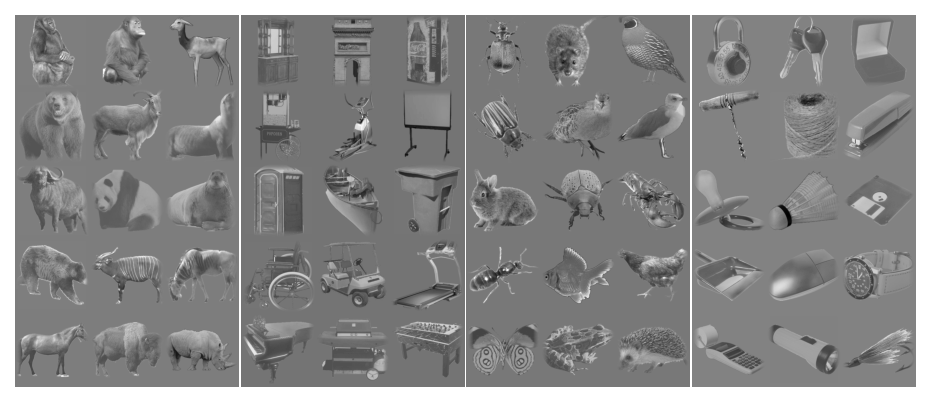

In [32]:
kwargs = dict(save='sfig1a', figsize=FIGSIZE['stim_suppl'])
plot_stim_examples('original', version='suppl', **kwargs)
plt.show(sns);

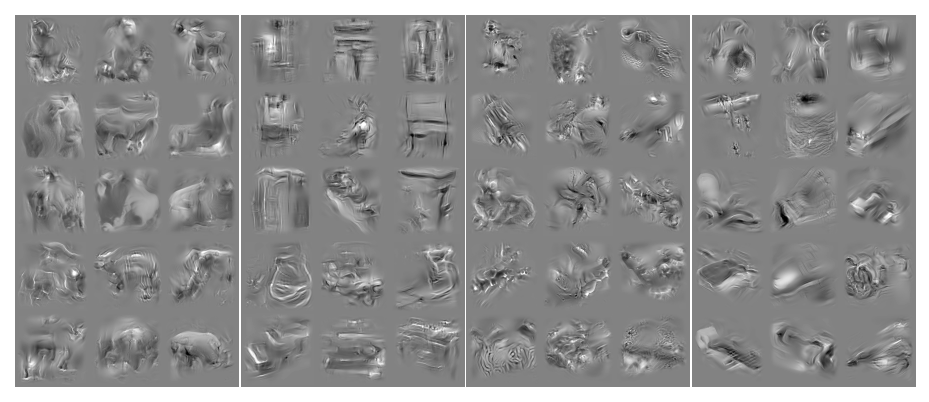

In [33]:
kwargs = dict(save='sfig1b', figsize=FIGSIZE['stim_suppl'])
plot_stim_examples('texform', version='suppl', **kwargs)
plt.show(sns);

#### Figure S2

Fig S2A. Animate vs Inanimate Cross-decoding


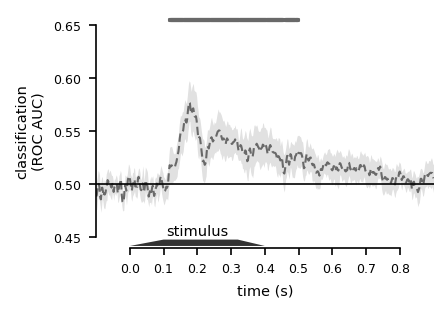

In [34]:
print('Fig S2A. Animate vs Inanimate Cross-decoding')
plot_category_decoding('animacy', SUPPL_DECODINGS.values(),
                       figsize=FIGSIZE['time_course'])
plt.show(sns);

Fig S2B. Big vs Small Cross-decoding


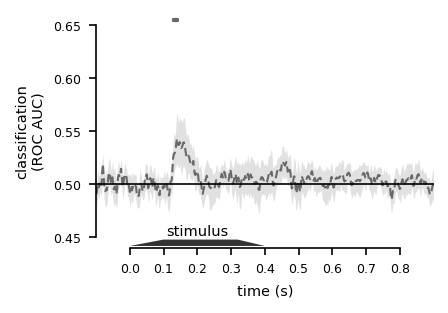

In [35]:
print('Fig S2B. Big vs Small Cross-decoding')
plot_category_decoding('size', SUPPL_DECODINGS.values(),
                       figsize=FIGSIZE['time_course'])
plt.show(sns);